# An Analysis

This notebook will be rendered on the website. Below is an example plot.

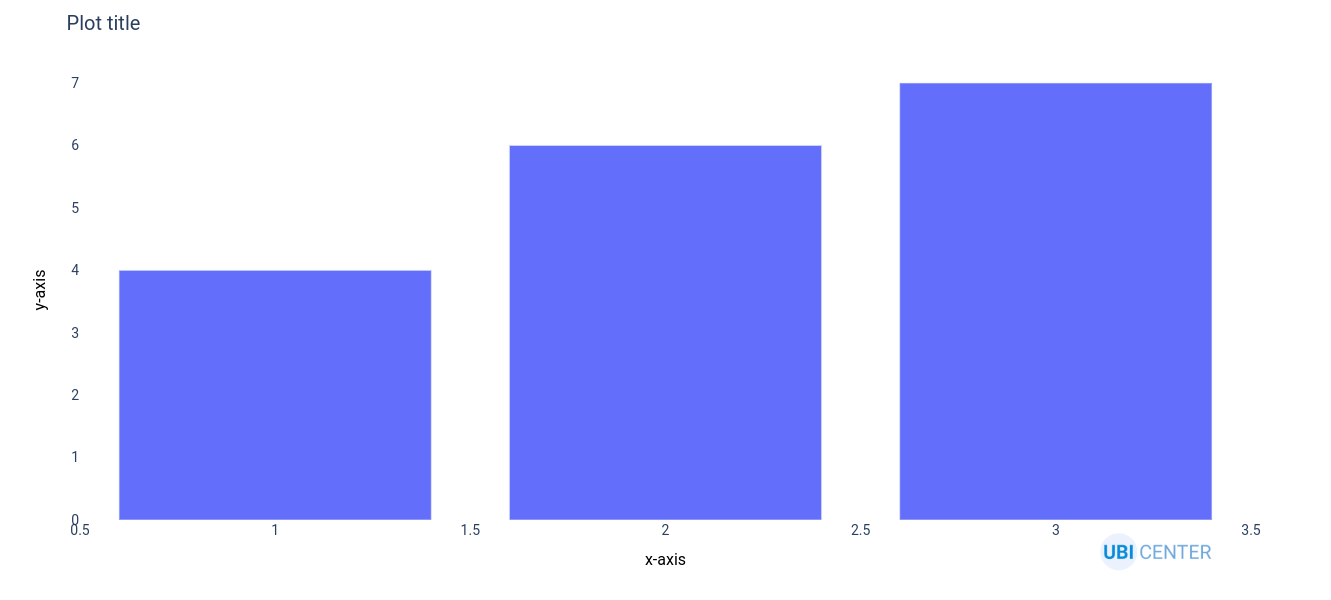

In [5]:
import plotly.express as px
from ubicenter import format_fig

format_fig(
    px.bar(
        x=[1, 2, 3], 
        y=[4, 6, 7]
    ).update_layout(
        title="Plot title",
        xaxis_title="x-axis",
        yaxis_title="y-axis"
    )
)